In [1]:
%matplotlib inline

import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import OrderedDict

from resspect import cosmo_metric_utils as cmu

In [2]:
# list of numbered files 
files = glob.glob('/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data/WFD/v*/summary_stats.csv')

In [3]:
remap_dict = OrderedDict({
                              'perfect3000': 'Perfect', 
                              'fiducial3000': 'Fiducial', 
                              'random3000': 'Random',
                              '72SNIa28SNII': 'SN-II 28',
                              '75SNIa25SNII': 'SN-II 25', 
                              '90SNIa10SNII': 'SN-II 10',
                              '95SNIa5SNII': 'SN-II 5',
                              '98SNIa2SNII': 'SN-II 2',
                              '99SNIa1SNII': 'SN-II 1',
                              '90SNIa10SNIbc': 'SN-Ibc 10',
                              '95SNIa5SNIbc': 'SN-Ibc 5',
                              '98SNIa2SNIbc': 'SN-Ibc 2',
                              '99SNIa1SNIbc': 'SN-Ibc 1',
                              '75SNIa25SNIax': 'SN-Iax 25',
                              '90SNIa10SNIax': 'SN-Iax 10',
                              '95SNIa5SNIax': 'SN-Iax 5',
                              '98SNIa2SNIax': 'SN-Iax 2',
                              '99SNIa1SNIax': 'SN-Iax 1',
                              '95SNIa5SNIa-91bg': 'SN-Ia-91bg 5',
                              '98SNIa2SNIa-91bg': 'SN-Ia-91bg 2',
                              '99SNIa1SNIa-91bg': 'SN-Ia-91bg 1',
                              '95SNIa5AGN': 'AGN 5',
                              '98SNIa2AGN': 'AGN 2',
                              '99SNIa1AGN': 'AGN 1',
                              '99.6SNIa0.4TDE': 'TDE 0.4',
                              '99.7SNIa0.3CART': 'CART 0.3',
                  })

all_shapes = {'SNIa-91bg': 'o',
              'SNIax': 's',
              'SNII': 'd',
              'SNIbc': 'X',
              'AGN': '^',
              'TDE': '<',
              'CART': 'v'}

color_nums = np.array([1, 1, 1,                    # Special
                       28, 25, 10, 5, 2, 1,        # II
                       10, 5, 2, 1,                # Ibc
                       25, 10, 5, 2, 1,            # Iax
                       5, 2, 1,                    # 91bg
                       5, 2, 1,                    # AGN
                       1,                          # TDE
                       1,                          # CART
                       ]) 

# Color map
rainbow = cm = plt.get_cmap('plasma_r')
cNorm  = colors.LogNorm(vmin=1, vmax=52) #colors.Normalize(vmin=0, vmax=50)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)
color_map = scalarMap.to_rgba(np.arange(1, 52))

In [4]:
summary_dict = {}

summary_dict['fom3'] = {}
summary_dict['KLD'] = {}
summary_dict['Wasserstein'] = {}
summary_dict['FM'] = {}
summary_dict['wfit'] = {}
summary_dict['wfit_std'] = {}
summary_dict['stan'] = {}
summary_dict['stan_std'] = {}


# j -> index from 0 to number of cases
# a -> case
# c -> contamination percentage. Cases with more than one contaminante are set to 1

for j, (a, c) in enumerate(zip(remap_dict, color_nums)):

    summary_dict['fom3'][a] = []
    summary_dict['KLD'][a] = []
    summary_dict['Wasserstein'][a] = []
    summary_dict['FM'][a] = []
    summary_dict['wfit'][a] = []
    summary_dict['wfit_std'][a] = []
    summary_dict['stan'][a] = []
    summary_dict['stan_std'][a] = []
    
    # f -> list of numbered files
    for f in files:
        
        df_t = pd.read_csv(f)
        
        if a in df_t['case'].values:
            summary_dict['fom3'][a].append(df_t['fom3'].loc[df_t['case'] == a].values[0])
            kld = df_t['KLD'].loc[df_t['case'] == a].values[0]
            summary_dict['KLD'][a].append(np.log(max([kld,1])))
            summary_dict['Wasserstein'][a].append(df_t['EMD'].loc[df_t['case'] == a].values[0])
            summary_dict['wfit'][a].append(df_t['wfit_w_lowz'].loc[df_t['case'] == a].values[0])
            summary_dict['wfit_std'][a].append(df_t['wfit_wsig_lowz'].loc[df_t['case'] == a].values[0])
            summary_dict['stan'][a].append(df_t['stan_w_lowz'].loc[df_t['case'] == a].values[0])
            summary_dict['stan_std'][a].append(df_t['stan_wsig_lowz'].loc[df_t['case'] == a].values[0])
        
    for i in range(1,6):
        # Fisher
        dist_loc_base = '/media/RESSPECT/data/PLAsTiCC/for_metrics/final_data/WFD/v' + str(i) + '/stan_input/' 
        
        df_fisher = pd.read_csv(dist_loc_base + '/stan_input_salt2mu_lowz_withbias_perfect3000.csv')
        sig_perf = cmu.fisher_results(df_fisher['z'].values, df_fisher['muerr'].values)[0]

        df_ = pd.read_csv(dist_loc_base + '/stan_input_salt2mu_lowz_withbias_'+ a + '.csv')
        sig = cmu.fisher_results(df_['z'].values, df_['muerr'].values)[0]
        summary_dict['FM'][a].append((sig[1]-sig_perf[1])/sig_perf[1])

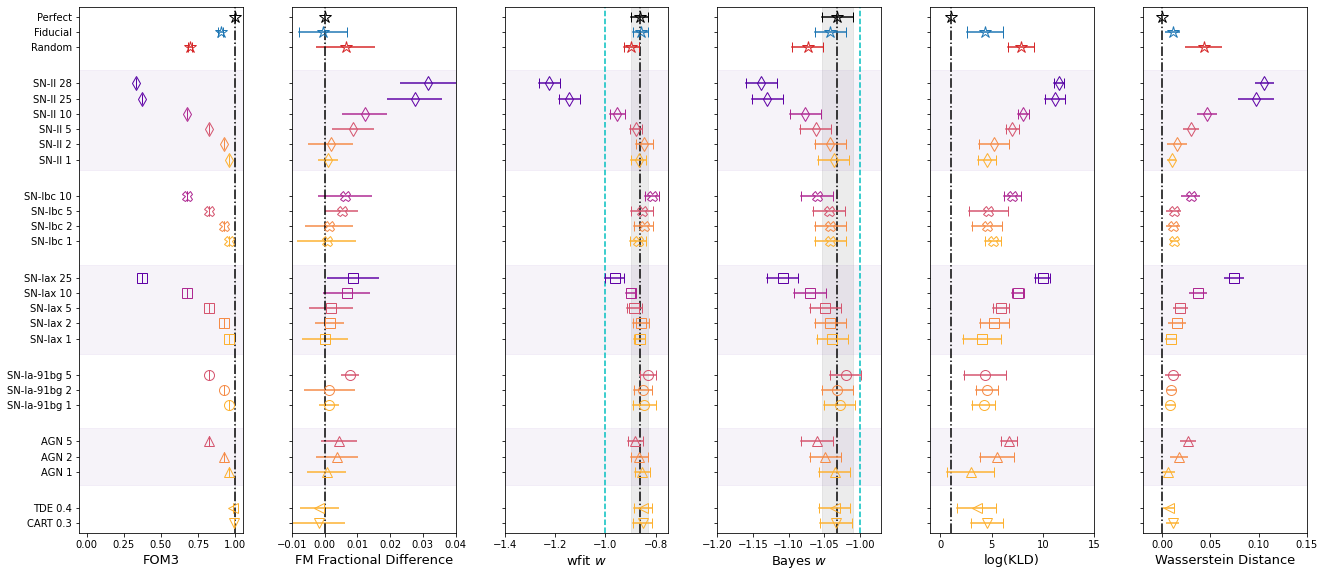

In [7]:
fig, axes = plt.subplots(1, 6, figsize=(22,10), sharey=True)

# wfit
ax1 = axes[2]

# Bayes
ax2 = axes[3]

ax1.axvline(-1, color='c', ls='--')
ax2.axvline(-1, color='c', ls='--')

wfit_perf_mean = np.mean(summary_dict['wfit']['perfect3000'])
wfit_perf_std = np.sqrt(sum([(item * item) for item in summary_dict['wfit_std']['perfect3000']])/5)

ax1.axvline(wfit_perf_mean, color='k', ls='-.')
ax1.axvspan(wfit_perf_mean - wfit_perf_std, 
            wfit_perf_mean +  wfit_perf_std, 
            alpha=0.15, color='grey')

stan_perf_mean =  np.mean(summary_dict['stan']['perfect3000'])
stan_perf_std = np.sqrt(sum([(item * item) for item in summary_dict['stan_std']['perfect3000']])/5)
ax2.axvline(stan_perf_mean, color='k', ls='-.')
ax2.axvspan(stan_perf_mean - stan_perf_std, 
            stan_perf_mean + stan_perf_std, 
            alpha=0.15, color='grey')

# FOM3
ax3 = axes[0]
fom_perf_mean =  np.mean(summary_dict['fom3']['perfect3000'])
fom_perf_std = np.std(summary_dict['fom3']['perfect3000'])
ax3.axvline(fom_perf_mean, color='k', ls='-.')
ax3.axvspan(fom_perf_mean - fom_perf_std, 
            fom_perf_mean +  fom_perf_std, 
            alpha=0.15, color='grey')

# Fisher
# percent different
ax4 = axes[1]
fisher_perf_mean =  np.mean(summary_dict['FM']['perfect3000'])
fisher_perf_std = np.std(summary_dict['FM']['perfect3000'])
ax4.axvline(fisher_perf_mean, color='k', ls='-.')
ax4.axvspan(fisher_perf_mean - fisher_perf_std, 
            fisher_perf_mean +  fisher_perf_std, 
            alpha=0.15, color='grey')


# Wasserstein
ax5 = axes[5]
ax5.axvline(0, color='k', ls='-.')


# KLD
ax6 = axes[4]
ax6.axvline(1, color='k', ls='-.')


i = 0
tick_lbls = []
i_list = []
for j, (a, c) in enumerate(zip(remap_dict, color_nums)):

    # wfit
    wfw = np.array([np.mean(summary_dict['wfit'][a])])
    wfw_sig = np.array([np.sqrt(sum([(item * item) for item in summary_dict['wfit_std'][a]])/5)])

    class_ = str.split(remap_dict[a])[0]
        
    # Fisher
    fm = np.array(np.nanmean(summary_dict['FM'][a]))
    fm_st = np.array(np.nanstd(summary_dict['FM'][a], ddof=1))
        
    # Wasserstein
    wsd = np.array([np.mean(summary_dict['Wasserstein'][a])])
    wsd_st = np.array([np.std(summary_dict['Wasserstein'][a], ddof=1)])
        
    # fom3
    #fom3 = df['fom3'].loc[df['case'] == a].values
    fom3 =  np.array([np.mean(summary_dict['fom3'][a])])
    fom3_sig = np.array([np.std(summary_dict['fom3'][a], ddof=1)])
        
    # KLD
    #kld = df['KLD'].loc[df['case'] == a].values
    kld = np.array(np.mean(summary_dict['KLD'][a]))
    kld_st = np.array(np.std(summary_dict['KLD'][a], ddof=1))

    if '91bg' in class_:
        class_ = 'SNIa-91bg'
    else:
        class_ = class_.replace('-', '')

    bad_data=False
    if wfw[0] < -2.2:
        wfw[0] = -1.4
        bad_data=True
        xuplims=[-1.5]
        
    mfc = "none"

    if 'fiducial' in a:
        if bad_data:
            ax1.errorbar(wfw, [-i], xerr=[0.03], marker='*',color='tab:blue',
                         xuplims=xuplims, markersize=12, mfc=mfc)
        else:
            ax1.plot(wfw, -i, '*', color='tab:blue', ms=12, mfc=mfc)
            ax1.plot([wfw - wfw_sig, wfw + wfw_sig], [-i, -i], "|-", color='tab:blue', ms=10)
    elif 'random' in a:
        if bad_data:
            ax1.errorbar(wfw, [-i], xerr=[0.03], marker='*',color='tab:red',
                         xuplims=xuplims, markersize=12, mfc=mfc)
        else:
            ax1.plot(wfw, -i, '*', color='tab:red', ms=12, mfc=mfc)
            ax1.plot([wfw - wfw_sig, wfw + wfw_sig], [-i, -i], "|-", color='tab:red', ms=10)
    elif 'perfect' in a:
        ax1.plot(wfw, -i, '*', color='k', ms=12, mfc=mfc)
        ax1.plot([wfw - wfw_sig, wfw + wfw_sig], [-i, -i], "|-", color='k', ms=10 )
    elif 'all_objs_survived' in a:
        ax1.plot(wfw, -i, '*', color='seagreen', ms=12, mfc=mfc)
        ax1.plot([wfw - wfw_sig, wfw + wfw_sig], [-i, -i], "|-", color='seagreen', ms=10 )
    else:
        if bad_data:
            ax1.errorbar(wfw, [-i], xerr=[0.03], marker=all_shapes[class_],color=color_map[c],
                         xuplims=xuplims, markersize=10)
        else:
            ax1.plot(wfw, -i, color=color_map[c], ms=10, marker=all_shapes[class_], mfc=mfc)
            ax1.plot([wfw - wfw_sig, wfw + wfw_sig], [-i, -i], "|-", color=color_map[c], ms=10)

    # Stan/Bayes
    bw = np.array([np.mean(summary_dict['stan'][a])])
    bw_sig = np.array([np.sqrt(sum([(item * item) for item in summary_dict['stan_std'][a]])/5)])
    #bw_sig = df['stan_wsig_lowz'].loc[df['case'] == a].values
        
    bad_data=False
    if bw[0] < -2.2:
        bw[0] = -1.4
        bad_data=True
        xuplims=[-1.5]

    if 'fiducial' in a:
        if bad_data:
            ax2.errorbar(bw, [-i], xerr=[0.03], marker='*',color='tab:blue',
                             xuplims=xuplims, markersize=12, mfc=mfc)
        else:
            ax2.plot(bw, -i, '*', color='tab:blue', ms=12, mfc=mfc)
            ax2.plot([bw - bw_sig, bw + bw_sig], [-i, -i], "|-", color='tab:blue', ms=10)
            ax3.plot(fom3, -i, '*', color='tab:blue', ms=12, mfc=mfc)
            ax3.plot([fom3 - fom3_sig, fom3 + fom3_sig], [-i, -i], "|-", color='tab:blue', ms=10)
            ax4.plot(fm, -i, '*', color='tab:blue', ms=12, mfc=mfc)
            ax4.plot([fm - fm_st, fm + fm_st], [-i, -i], "|-", color='tab:blue', ms=10)
            #ax4.errorbar(fm, np.array([-i]), xerr=fm_st, marker='*', color='tab:blue', ms=10, mfc=mfc)
            ax5.errorbar(wsd, np.array([-i]), xerr=wsd_st, marker='*', color='tab:blue', ms=12, mfc=mfc)
            ax6.plot(kld, np.array([-i]), marker='*', color='tab:blue', ms=12, mfc=mfc)
            ax6.plot([kld - kld_st, kld + kld_st], [-i, -i], "|-", color='tab:blue', ms=12)
      
    elif 'random' in a:
        if bad_data:
            ax2.errorbar(bw, [-i], xerr=[0.03], marker='*',color='tab:red',
                             xuplims=xuplims, markersize=12, mfc=mfc)
        else:
            ax2.plot(bw, -i, '*', color='tab:red', ms=12, mfc=mfc)
            ax2.plot([bw - bw_sig, bw + bw_sig], [-i, -i], "|-", color='tab:red', ms=10)
            ax3.plot(fom3, -i, '*', color='tab:red', ms=12, mfc=mfc)
            ax3.plot([fom3 - fom3_sig, fom3 + fom3_sig], [-i, -i], "|-", color='tab:red', ms=10)
            ax4.errorbar(fm, np.array([-i]), marker='*', xerr=fm_st, color='tab:red', ms=12, mfc=mfc)
            ax5.errorbar(wsd, np.array([-i]), marker='*', xerr=wsd_st, color='tab:red', ms=12, mfc=mfc)
            if kld > 750:
                ax6.errorbar(700, [-i], xerr=[1e10], marker='*',color='tab:red',
                                 xlolims=True, xuplims=[900],
                                 markersize=12, mfc=mfc)
            else:
                #ax6.semilogx(kld, -i, '*', color='tab:red', ms=12, mfc=mfc)
                ax6.plot(kld, np.array([-i]), marker='*', color='tab:red', ms=12, mfc=mfc)
                ax6.plot([kld - kld_st, kld + kld_st], [-i, -i], "|-", color='tab:red', ms=10)
    elif 'perfect' in a:
        ax2.plot(bw, -i, '*', color='k', ms=12, mfc=mfc)
        ax2.plot([bw - bw_sig, bw + bw_sig], [-i, -i], "|-", color='k', ms=10 )
        ax3.plot(fom3, -i, '*', color='k', ms=12, mfc=mfc)
        ax3.plot([fom3 - fom3_sig, fom3 + fom3_sig], [-i, -i], "|-", color='k', ms=10 )
        ax4.plot(0, -i, '*', color='k', ms=12, mfc=mfc)
        ax5.plot(0, -i, '*', color='k', ms=12, mfc=mfc)
        ax6.plot(1, -i, '*', color='k', ms=12, mfc=mfc)
    else:
        ax2.plot(bw, -i, color=color_map[c], ms=10, marker=all_shapes[class_], mfc=mfc)
        ax2.plot([bw - bw_sig, bw + bw_sig], [-i, -i], "|-", color=color_map[c], ms=10)
        ax3.plot(fom3, -i, color=color_map[c], ms=10, marker=all_shapes[class_], mfc=mfc)
        ax3.plot([fom3 - fom3_sig, fom3 + fom3_sig], [-i, -i], "|-", color=color_map[c], ms=10)
        ax4.errorbar(fm, np.array([-i]), xerr=fm_st, color=color_map[c], ms=10, marker=all_shapes[class_], mfc=mfc)
        ax5.errorbar(wsd, np.array([-i]), xerr=wsd_st, color=color_map[c], ms=10, marker=all_shapes[class_], mfc=mfc)
        if kld > 750:
            ax6.errorbar(700, [-i], xerr=[1e10],  marker=all_shapes[class_], color=color_map[c],
                                 xlolims=True, 
                                 markersize=10, mfc=mfc)
            
        else:
            ax6.plot(kld, -i, color=color_map[c], ms=10, marker=all_shapes[class_], mfc=mfc)
            ax6.plot([kld - kld_st, kld + kld_st], [-i, -i], "|-", color=color_map[c], ms=10)
            #ax6.errorbar(kld, np.array([-i]), xerr=kld_st,color=color_map[c], ms=10, marker=all_shapes[class_], mfc=mfc)
            #ax6.scatter(kld)
        
    tick_lbls.append(remap_dict[a])
    i_list.append(-i)
    i +=0.8
        
    if 'random' in a or '99SNIa1' in a:
        i_list.append(-i)
        i += 1.1
        tick_lbls.append('')

tick_locs = i_list[::-1]
ax1.set_yticks(tick_locs)
ax1.set_yticklabels(tick_lbls[::-1], fontsize=13)

ax1.set_ylim(i_list[-1]-0.5, i_list[0]+0.5)#-len(tick_lbls)+0.5, 0.5)


ax1.set_xlabel(r'wfit $w$', fontsize=13)
ax2.set_xlabel(r'Bayes $w$', fontsize=13)
ax3.set_xlabel('FOM3', fontsize=13)
ax4.set_xlabel('FM Fractional Difference', fontsize=13)
ax5.set_xlabel('Wasserstein Distance', fontsize=13)
ax6.set_xlabel('log(KLD)', fontsize=13)
plt.subplots_adjust(bottom=0.15, wspace=0.3) # wspace=0.05


ax1.set_xlim(-1.4, -0.75)
ax2.set_xlim(-1.2, -0.97)
ax3.set_xlim(-0.05, 1.05)
ax4.set_xlim(-0.01, 0.04)
ax5.set_xlim(-0.02, 0.15)
ax6.set_xlim(-1, 15)

ticks = [-4, -11, -16, -22, -26, -30]
    
for ax in axes:
    for t in ticks:
        yticks = ax.yaxis.get_major_ticks()
        yticks[t].set_visible(False)
    ax.axvspan(-1.5, 2e10, ymin=0.69, ymax=0.88, alpha=0.08, color='tab:purple')
    ax.axvspan(-1.5, 2e10, ymin=0.34, ymax=0.51, alpha=0.08, color='tab:purple')
    ax.axvspan(-1.5, 2e10, ymin=0.09, ymax=0.2, alpha=0.08, color='tab:purple')
    
#plt.savefig('combined_metrics_WFD_all_versions.png', bbox_inches='tight')
plt.show()
